In [1]:
pip install yfinance


In [3]:
import yfinance as yf
import pandas as pd
from datetime import datetime

# List of 10 Indian stocks with their Yahoo Finance ticker symbols
# Note: Indian stock tickers end with ".NS" (NSE)
indian_stocks = {
    "RELIANCE": "RELIANCE.NS",
    "TCS": "TCS.NS",
    "INFY": "INFY.NS",
    "HDFCBANK": "HDFCBANK.NS",
    "ICICIBANK": "ICICIBANK.NS",
    "SBIN": "SBIN.NS",
    "LT": "LT.NS",
    "ITC": "ITC.NS",
    "KOTAKBANK": "KOTAKBANK.NS",
    "BAJFINANCE": "BAJFINANCE.NS"
}

# Define date range for the last 10 years
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today().replace(year=datetime.today().year - 10)).strftime('%Y-%m-%d')

# Fetch and save data
for name, ticker in indian_stocks.items():
    print(f"Fetching data for {name}...")
    data = yf.download(ticker, start=start_date, end=end_date)
    
    if not data.empty:
        csv_filename = f"{name}_10yr_data.csv"
        data.to_csv(csv_filename)
        print(f"Saved to {csv_filename}")
    else:
        print(f"No data found for {name} ({ticker})")

print("✅ Done fetching and saving stock data.")


Fetching data for RELIANCE...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Saved to RELIANCE_10yr_data.csv
Fetching data for TCS...


[*********************100%***********************]  1 of 1 completed


Saved to TCS_10yr_data.csv
Fetching data for INFY...


[*********************100%***********************]  1 of 1 completed


Saved to INFY_10yr_data.csv
Fetching data for HDFCBANK...


[*********************100%***********************]  1 of 1 completed


Saved to HDFCBANK_10yr_data.csv
Fetching data for ICICIBANK...


[*********************100%***********************]  1 of 1 completed


Saved to ICICIBANK_10yr_data.csv
Fetching data for SBIN...


[*********************100%***********************]  1 of 1 completed


Saved to SBIN_10yr_data.csv
Fetching data for LT...


[*********************100%***********************]  1 of 1 completed


Saved to LT_10yr_data.csv
Fetching data for ITC...


[*********************100%***********************]  1 of 1 completed


Saved to ITC_10yr_data.csv
Fetching data for KOTAKBANK...


[*********************100%***********************]  1 of 1 completed


Saved to KOTAKBANK_10yr_data.csv
Fetching data for BAJFINANCE...


[*********************100%***********************]  1 of 1 completed

Saved to BAJFINANCE_10yr_data.csv
✅ Done fetching and saving stock data.


In [5]:
pip install yfinance arch pandas numpy scipy


Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from arch import arch_model
import os

# Parameters
dividend_yield_monthly = 0.002
risk_free_rate = 0.07
option_types = ['call', 'put']
times_to_maturity = [30, 90, 180]

stock_names = [
    "RELIANCE", "TCS", "INFY", "HDFCBANK", "ICICIBANK",
    "SBIN", "LT", "ITC", "KOTAKBANK", "BAJFINANCE"
]

def black_scholes_price(S, K, T, r, sigma, option_type, q=0.0):
    T_years = T / 365
    if T_years == 0 or sigma == 0:
        return max(0, S - K) if option_type == 'call' else max(0, K - S), 0

    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T_years) / (sigma * np.sqrt(T_years))
    d2 = d1 - sigma * np.sqrt(T_years)

    if option_type == 'call':
        price = S * np.exp(-q * T_years) * norm.cdf(d1) - K * np.exp(-r * T_years) * norm.cdf(d2)
        delta = np.exp(-q * T_years) * norm.cdf(d1)
    else:
        price = K * np.exp(-r * T_years) * norm.cdf(-d2) - S * np.exp(-q * T_years) * norm.cdf(-d1)
        delta = -np.exp(-q * T_years) * norm.cdf(-d1)

    return price, delta

for stock in stock_names:
    input_file = f"{stock}_10yr_data.csv"
    output_file = f"{stock}_option_features.csv"

    if not os.path.exists(input_file):
        print(f"❌ File not found: {input_file}")
        continue

    print(f"🔄 Processing: {input_file}")
    df = pd.read_csv(input_file)

    # Ensure 'Close' is numeric
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    df = df.dropna(subset=['Close'])

    # Use Close for returns and spot price
    returns = 100 * df['Close'].pct_change().dropna()

    try:
        garch = arch_model(returns, vol='Garch', p=1, q=1)
        garch_result = garch.fit(disp="off")
        forecast = garch_result.forecast(horizon=1)
        volatility = np.sqrt(forecast.variance.values[-1][0]) / 100
    except Exception as e:
        print(f"⚠️ GARCH model failed for {stock}: {e}")
        continue

    spot_price = df['Close'].iloc[-1]
    strike_prices = np.arange(spot_price * 0.8, spot_price * 1.2, 20)

    rows = []

    for T in times_to_maturity:
        for K in strike_prices:
            for opt_type in option_types:
                price, delta = black_scholes_price(
                    S=spot_price,
                    K=K,
                    T=T,
                    r=risk_free_rate,
                    sigma=volatility,
                    option_type=opt_type,
                    q=dividend_yield_monthly * 12
                )

                rows.append({
                    "Time to Maturity (days)": T,
                    "Option Type": opt_type,
                    "Delta": delta,
                    "Strike Price": K,
                    "Spot Price": spot_price,
                    "Theoretical Price": price,
                    "Monthly Dividend Rate": dividend_yield_monthly,
                    "Risk-Free Rate": risk_free_rate,
                    "Volatility (GARCH)": volatility
                })

    feature_df = pd.DataFrame(rows)
    feature_df.to_csv(output_file, index=False)
    print(f"✅ Saved: {output_file}")


🔄 Processing: RELIANCE_10yr_data.csv
✅ Saved: RELIANCE_option_features.csv
🔄 Processing: TCS_10yr_data.csv
✅ Saved: TCS_option_features.csv
🔄 Processing: INFY_10yr_data.csv
✅ Saved: INFY_option_features.csv
🔄 Processing: HDFCBANK_10yr_data.csv
✅ Saved: HDFCBANK_option_features.csv
🔄 Processing: ICICIBANK_10yr_data.csv
✅ Saved: ICICIBANK_option_features.csv
🔄 Processing: SBIN_10yr_data.csv
✅ Saved: SBIN_option_features.csv
🔄 Processing: LT_10yr_data.csv
✅ Saved: LT_option_features.csv
🔄 Processing: ITC_10yr_data.csv
✅ Saved: ITC_option_features.csv
🔄 Processing: KOTAKBANK_10yr_data.csv
✅ Saved: KOTAKBANK_option_features.csv
🔄 Processing: BAJFINANCE_10yr_data.csv
✅ Saved: BAJFINANCE_option_features.csv


In [9]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Define current directory
current_dir = os.getcwd()

# Output folder for processed files
output_folder = os.path.join(current_dir, "option_data_processed")
os.makedirs(output_folder, exist_ok=True)

# Define features and target
feature_columns = [
    'Time to Maturity (days)',
    'Option Type',
    'Delta',
    'Strike Price',
    'Spot Price',
    'Monthly Dividend Rate',
    'Risk-Free Rate',
    'Volatility (GARCH)'
]
target_column = 'Theoretical Price'

# Process all relevant CSVs in the current directory
for file_name in os.listdir(current_dir):
    if not file_name.endswith('_option_features.csv'):
        continue

    file_path = os.path.join(current_dir, file_name)
    df = pd.read_csv(file_path)

    # Encode Option Type
    if 'Option Type' in df.columns:
        df['Option Type'] = df['Option Type'].map({'call': 1, 'put': 0})
    
    # Drop missing rows
    df.dropna(inplace=True)

    # Skip files with missing columns
    missing_cols = set(feature_columns + [target_column]) - set(df.columns)
    if missing_cols:
        print(f"Skipping {file_name}, missing columns: {missing_cols}")
        continue

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[feature_columns])
    y = df[target_column].values

    # Combine scaled features with target
    processed_df = pd.DataFrame(X_scaled, columns=feature_columns)
    processed_df[target_column] = y

    # Save to processed folder
    output_path = os.path.join(output_folder, f"processed_{file_name}")
    processed_df.to_csv(output_path, index=False)
    print(f"Saved: {output_path}")


Saved: C:\Users\Lenovo\option_pricing_with_DL\option_data_processed\processed_BAJFINANCE_option_features.csv
Saved: C:\Users\Lenovo\option_pricing_with_DL\option_data_processed\processed_HDFCBANK_option_features.csv
Saved: C:\Users\Lenovo\option_pricing_with_DL\option_data_processed\processed_ICICIBANK_option_features.csv
Saved: C:\Users\Lenovo\option_pricing_with_DL\option_data_processed\processed_INFY_option_features.csv
Saved: C:\Users\Lenovo\option_pricing_with_DL\option_data_processed\processed_ITC_option_features.csv
Saved: C:\Users\Lenovo\option_pricing_with_DL\option_data_processed\processed_KOTAKBANK_option_features.csv
Saved: C:\Users\Lenovo\option_pricing_with_DL\option_data_processed\processed_LT_option_features.csv
Saved: C:\Users\Lenovo\option_pricing_with_DL\option_data_processed\processed_RELIANCE_option_features.csv
Saved: C:\Users\Lenovo\option_pricing_with_DL\option_data_processed\processed_SBIN_option_features.csv
Saved: C:\Users\Lenovo\option_pricing_with_DL\option

In [13]:
pip install torch torchvision torchaudio


   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ----------------------------- ---------- 1.8/2.5 MB 25.4 MB/s eta 0:00:01
   ---------------------------------------- 2.5/2.5 MB 10.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [17]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# CKAN-style Conv model (simplified)
class ConvKAN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(ConvKAN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        return self.fc2(x).squeeze()

input_dir = "./option_data_processed"
all_predictions = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for file_name in os.listdir(input_dir):
    if not file_name.endswith(".csv"):
        continue

    df = pd.read_csv(os.path.join(input_dir, file_name))
    feature_columns = df.columns[:-1]
    target_column = df.columns[-1]

    X = torch.tensor(df[feature_columns].values, dtype=torch.float32).to(device)
    y = torch.tensor(df[target_column].values, dtype=torch.float32).to(device)

    dataset = TensorDataset(X, y)
    loader = DataLoader(dataset, batch_size=64, shuffle=True)

    model = ConvKAN(input_dim=X.shape[1]).to(device)
    optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)  # Changed optimizer here
    loss_fn = nn.SmoothL1Loss()  # Huber loss (SmoothL1Loss in PyTorch)

    # Train model
    model.train()
    for epoch in range(50):
        for batch_X, batch_y in loader:
            optimizer.zero_grad()
            pred = model(batch_X)
            loss = loss_fn(pred, batch_y)
            loss.backward()
            optimizer.step()

    # Predict
    model.eval()
    with torch.no_grad():
        predictions = model(X).cpu().numpy()

    ticker = file_name.replace("processed_", "").replace("_option_features.csv", "")
    all_predictions[ticker] = predictions

    print(f"Predictions for {ticker}:")
    print(predictions[:5])  # First 5 predicted option prices


Predictions for BAJFINANCE:
[1838.4604     38.34581  1820.9792     34.064526 1803.1432  ]
Predictions for HDFCBANK:
[381.60675      0.85165495 363.70746      0.49896306 345.71716   ]
Predictions for ICICIBANK:
[280.20917   20.129799 267.89465   15.347078 252.4224  ]
Predictions for INFY:
[301.01117     7.362854  285.9399      6.0889907 269.4457   ]
Predictions for ITC:
[71.71613     1.7021034  61.8162     -0.27539116 48.65298   ]
Predictions for KOTAKBANK:
[401.97028     1.5132061 385.06287     1.2971126 366.58087  ]
Predictions for LT:
[724.91      37.120846 709.29596   31.294619 692.19916 ]
Predictions for RELIANCE:
[256.7938    13.867959 244.59334    9.808041 231.72197 ]
Predictions for SBIN:
[145.54933     4.3204207 133.9961      1.4701333 120.90216  ]
Predictions for TCS:
[ 6.7535742e+02 -3.7820549e-03  6.6083923e+02 -3.7820549e-03
  6.4420673e+02]


In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# all_predictions: dict {ticker: predicted_values}
# We will reload actual values for each ticker from processed CSV files
input_dir = "./option_data_processed"

all_true = []
all_pred = []

print("Evaluation Metrics per ticker:\n")

for ticker, preds in all_predictions.items():
    file_path = f"{input_dir}/processed_{ticker}_option_features.csv"
    df = pd.read_csv(file_path)
    y_true = df['Theoretical Price'].values

    mse = mean_squared_error(y_true, preds)
    mae = mean_absolute_error(y_true, preds)
    r2 = r2_score(y_true, preds)

    print(f"{ticker}:")
    print(f"  MSE  = {mse:.4f}")
    print(f"  MAE  = {mae:.4f}")
    print(f"  R2   = {r2:.4f}\n")

    all_true.extend(y_true)
    all_pred.extend(preds)

# Overall metrics across all tickers
mse_all = mean_squared_error(all_true, all_pred)
mae_all = mean_absolute_error(all_true, all_pred)
r2_all = r2_score(all_true, all_pred)

print("Overall model performance:")
print(f"  MSE  = {mse_all:.4f}")
print(f"  MAE  = {mae_all:.4f}")
print(f"  R2   = {r2_all:.4f}")


Evaluation Metrics per ticker:

BAJFINANCE:
  MSE  = 1018.2570
  MAE  = 22.4779
  R2   = 0.9971

HDFCBANK:
  MSE  = 78.6767
  MAE  = 4.8470
  R2   = 0.9950

ICICIBANK:
  MSE  = 287.4549
  MAE  = 11.1285
  R2   = 0.9671

INFY:
  MSE  = 195.1070
  MAE  = 8.3664
  R2   = 0.9814

ITC:
  MSE  = 72.7267
  MAE  = 5.4958
  R2   = 0.9123

KOTAKBANK:
  MSE  = 69.6189
  MAE  = 4.8394
  R2   = 0.9962

LT:
  MSE  = 861.5818
  MAE  = 17.9102
  R2   = 0.9846

RELIANCE:
  MSE  = 360.1496
  MAE  = 13.6022
  R2   = 0.9583

SBIN:
  MSE  = 187.6737
  MAE  = 9.3646
  R2   = 0.9364

TCS:
  MSE  = 108.7615
  MAE  = 6.0742
  R2   = 0.9978

Overall model performance:
  MSE  = 559.2209
  MAE  = 14.2331
  R2   = 0.9967


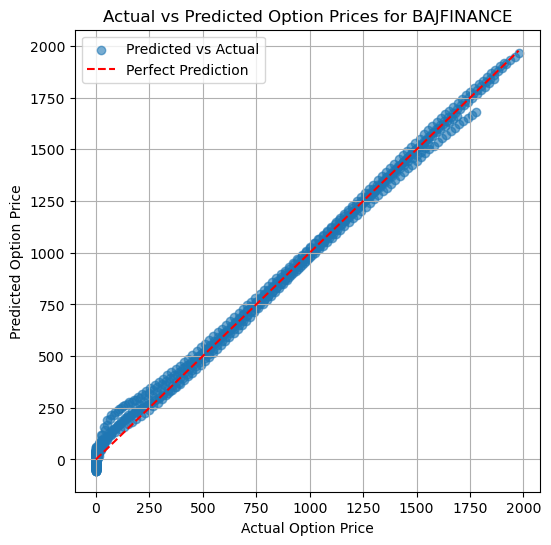

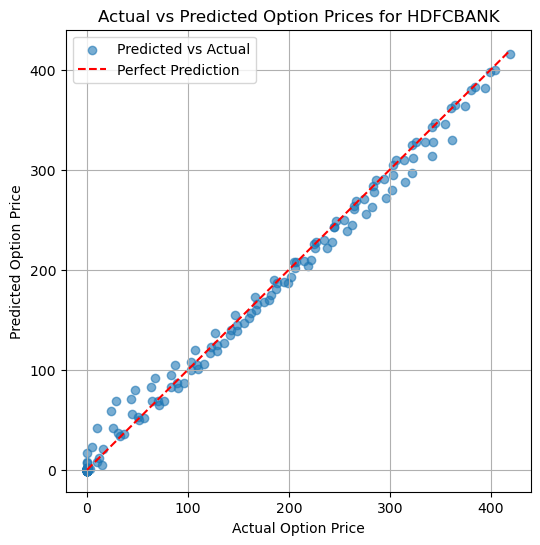

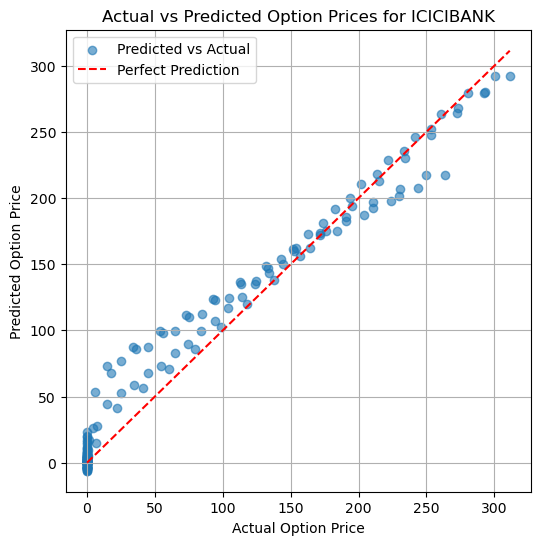

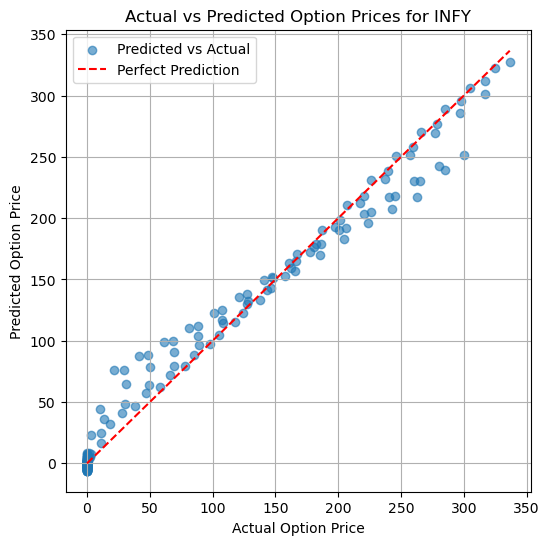

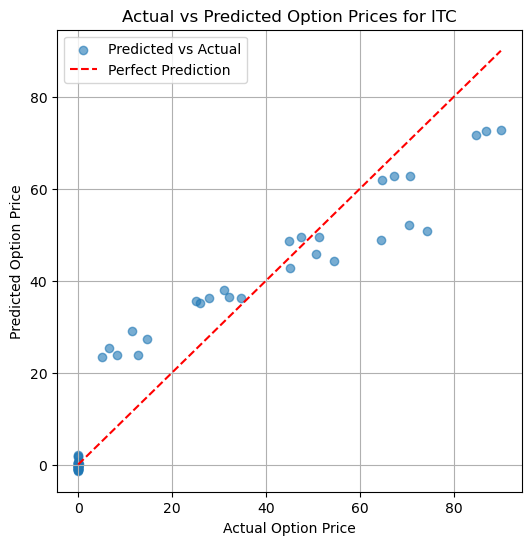

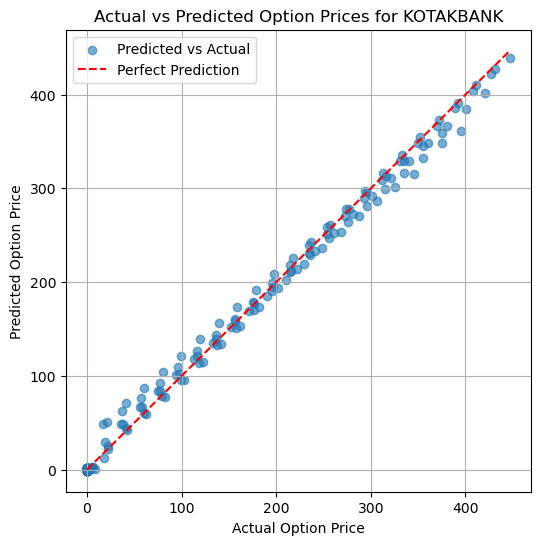

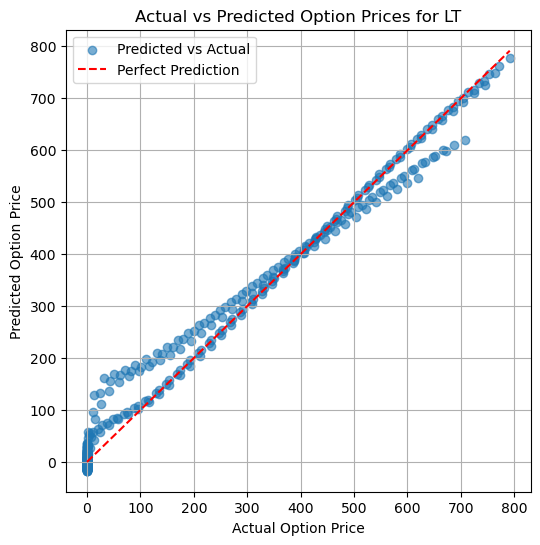

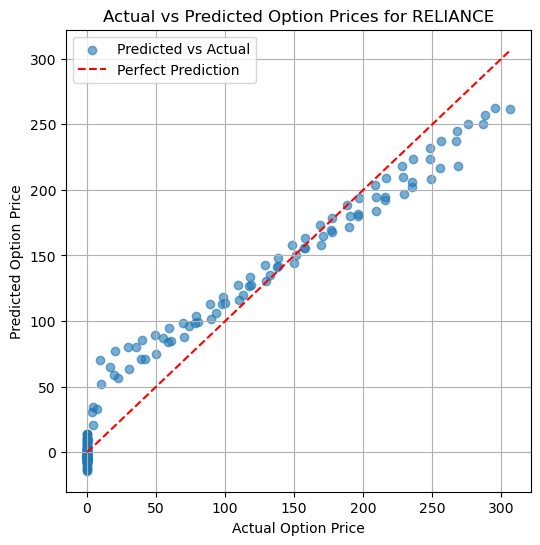

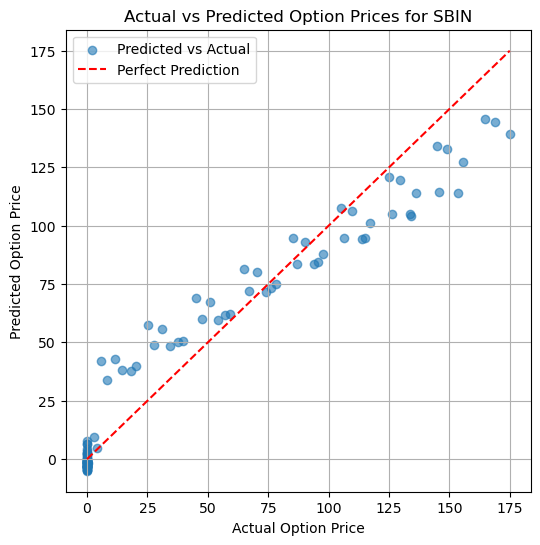

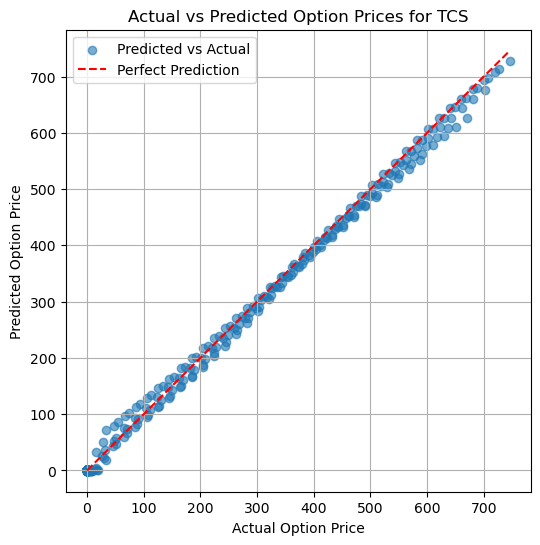

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import os

input_dir = "./option_data_processed"

for ticker, preds in all_predictions.items():
    file_path = os.path.join(input_dir, f"processed_{ticker}_option_features.csv")
    df = pd.read_csv(file_path)
    y_true = df['Theoretical Price'].values

    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, preds, alpha=0.6, label='Predicted vs Actual')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Perfect Prediction')
    plt.xlabel('Actual Option Price')
    plt.ylabel('Predicted Option Price')
    plt.title(f'Actual vs Predicted Option Prices for {ticker}')
    plt.legend()
    plt.grid(True)
    plt.show()
